In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label

In [2]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Tue, 21 Mar 2023 13:17:33] [INFO    ] [topostats] Extracting image from flat\20230118_KPN001.0_00005.spm
[Tue, 21 Mar 2023 13:17:33] [INFO    ] [topostats] Loading image from : flat\20230118_KPN001.0_00005.spm
[Tue, 21 Mar 2023 13:17:33] [INFO    ] [topostats] [20230118_KPN001.0_00005] : Loaded image from : flat\20230118_KPN001.0_00005.spm
[Tue, 21 Mar 2023 13:17:33] [INFO    ] [topostats] [20230118_KPN001.0_00005] : Extracted channel Height
[Tue, 21 Mar 2023 13:17:33] [INFO    ] [topostats] [20230118_KPN001.0_00005] : Pixel to nm scaling : 12.8654296875


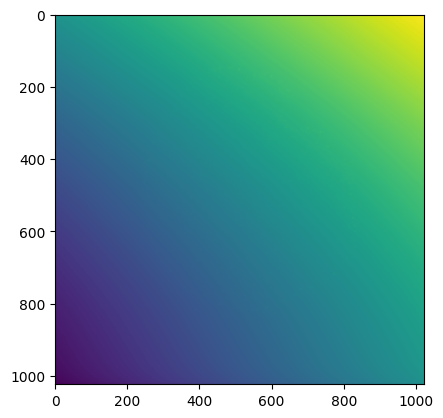

In [21]:
    #Flat
file = Path('./flat/20230118_KPN001.0_00005.spm')
#file = Path('./Flat/20230118_KPN001.0_00011.spm')
# file = Path('./flat/20230118_KPN001.0_00023.spm')
# file = Path('./flat/20230125_KPN005.0_00006.spm')
# file = Path('./flat/20230125_KPN005.0_00028.spm')
# file = Path('./flat/20230126_KPN005.0_00004.spm')
# file = Path('./flat/20230126_KPN005.0_00013.spm')
# file = Path('./flat/20230126_KPN005.0_00019.spm')
# file = Path('./flat/20230126_KPN005.0_00024.spm')
# file = Path('./flat/20230217_KPN010.0_00010.spm')
# file = Path('./flat/20230314_KPN015.0_00016.spm')
    #Folded
# file = Path('./flat')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [22]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Tue, 21 Mar 2023 13:17:45] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : Median flattening without mask
[Tue, 21 Mar 2023 13:17:46] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : Plane tilt removal without mask
[Tue, 21 Mar 2023 13:17:46] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : x-polyfit 1st order: [  0.07508846 -38.44097541]
[Tue, 21 Mar 2023 13:17:46] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : y-polyfit 1st order: [-3.93572911e-19  2.88048718e-16]
[Tue, 21 Mar 2023 13:17:46] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : Removing x plane tilt
[Tue, 21 Mar 2023 13:17:48] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : removing y plane tilt
[Tue, 21 Mar 2023 13:17:50] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : Remove quadratic bow without mask
[Tue, 21 Mar 2023 13:17:50] [INFO    ] [topostats] [flat\20230118_KPN001.0_00005.spm] : x polyfit 2nd order: [ 6.04952624e-07 -6.18866534e-

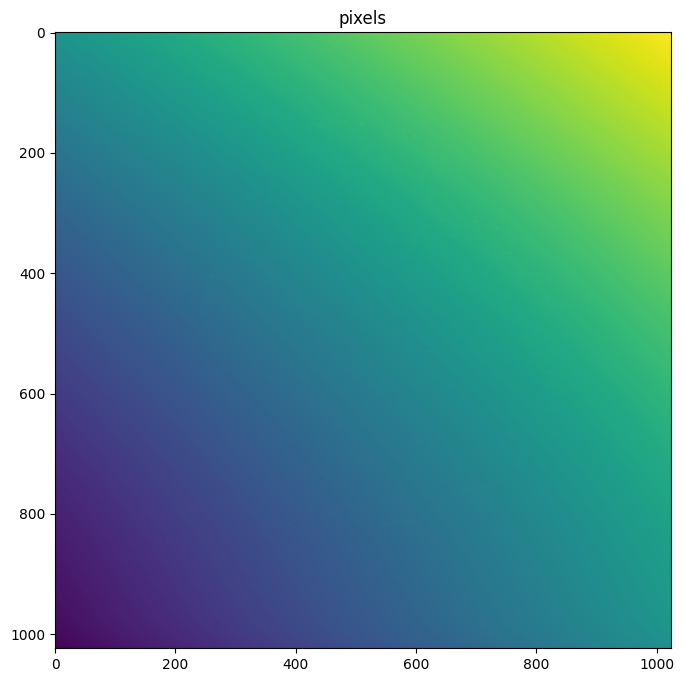

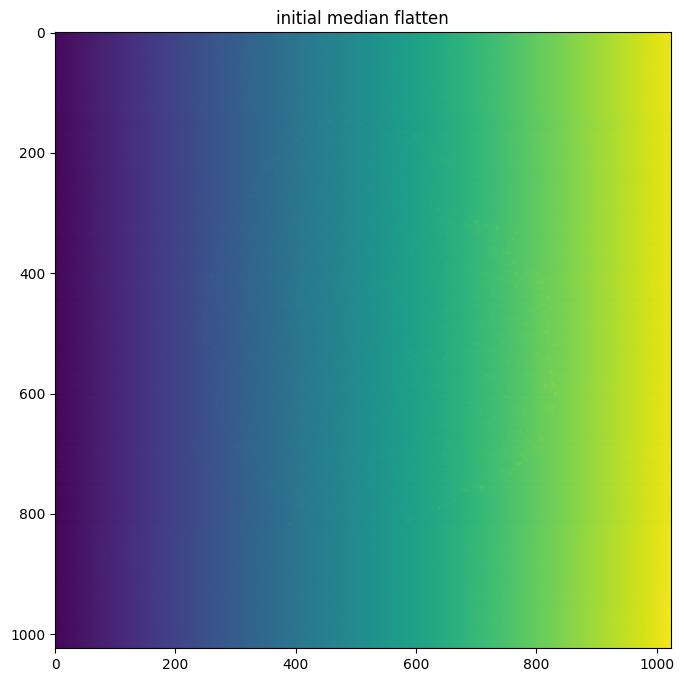

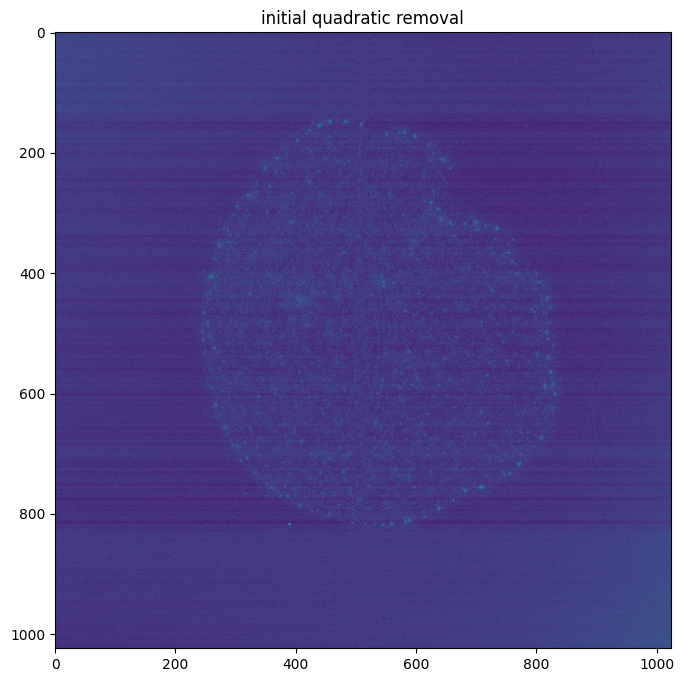

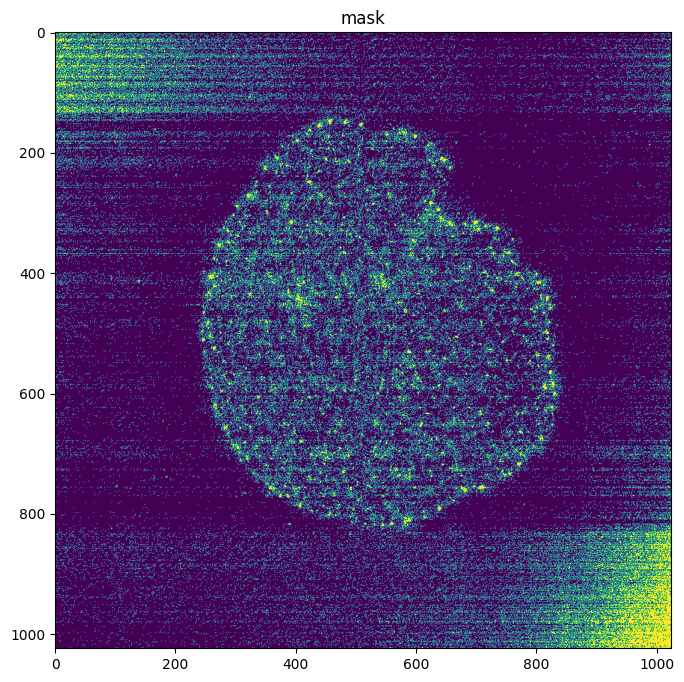

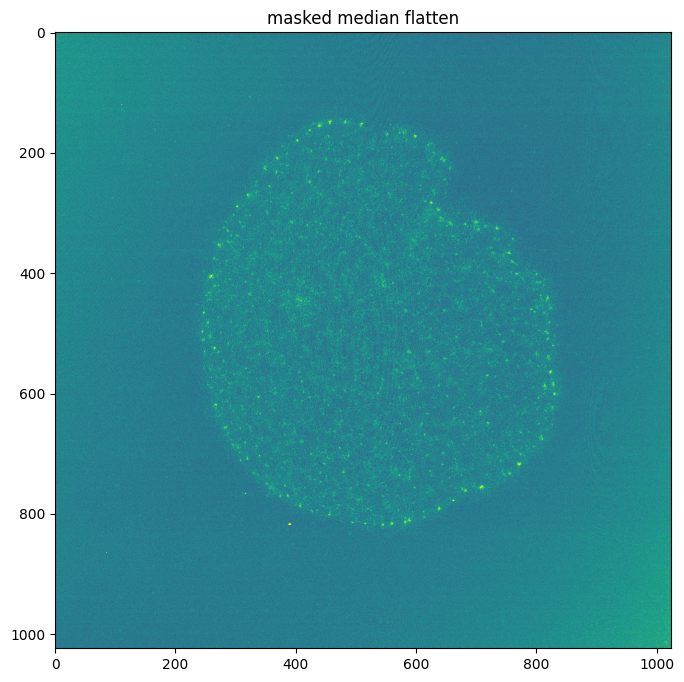

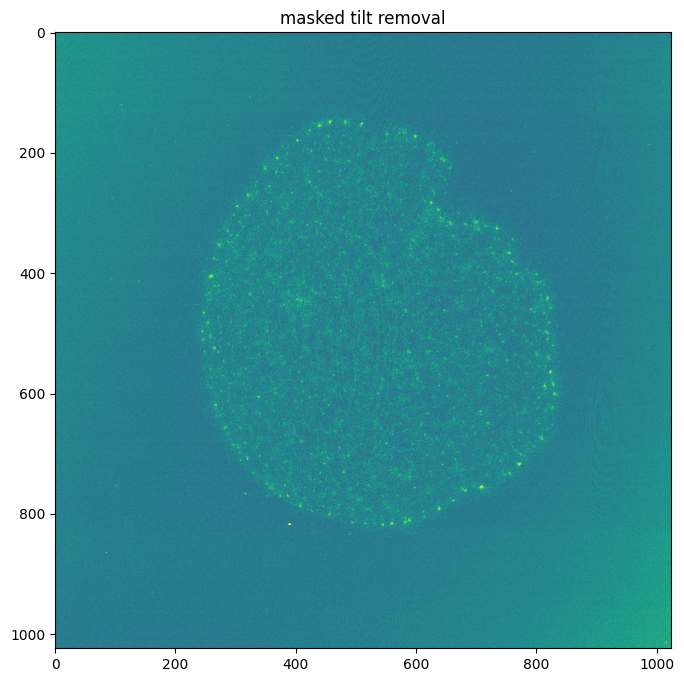

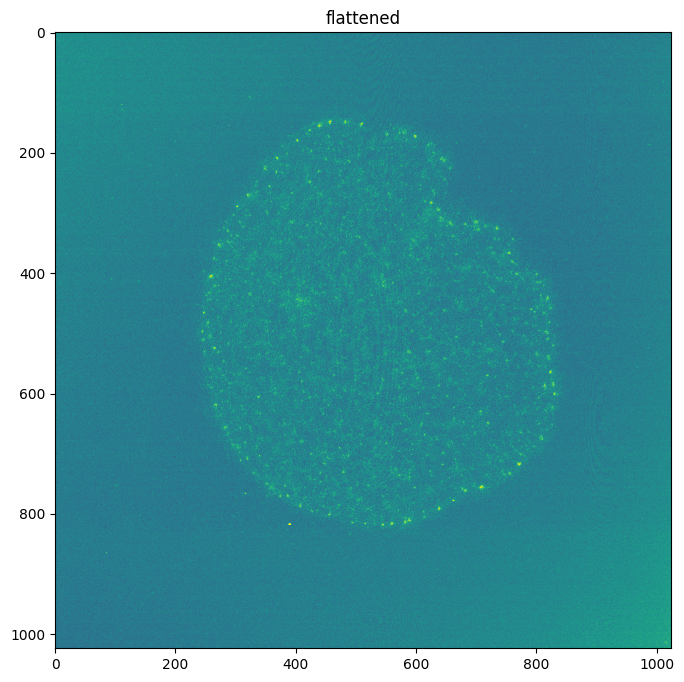

In [23]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 0.5926779281950045})
[Tue, 21 Mar 2023 13:18:38] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.5926779281950045


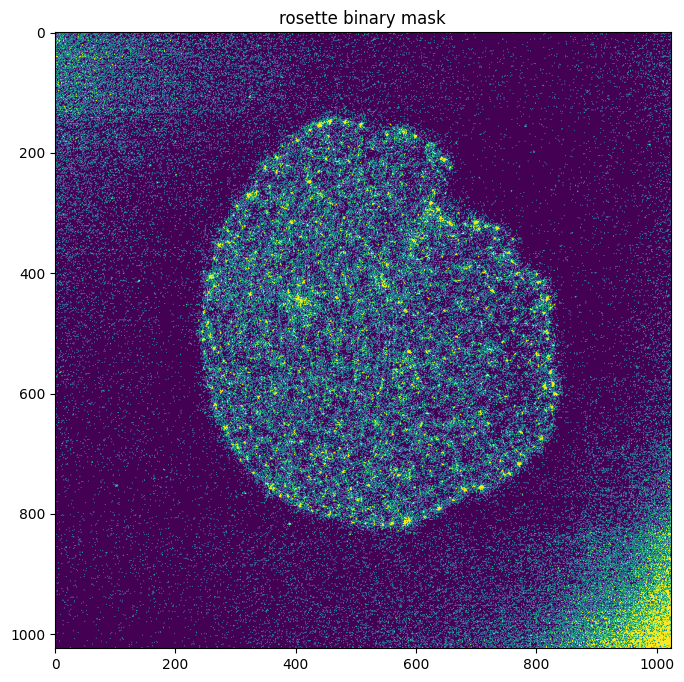

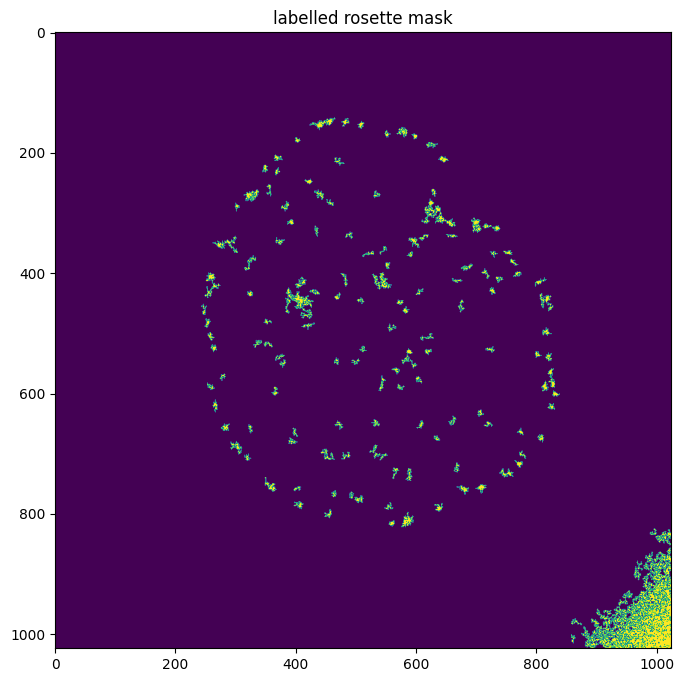

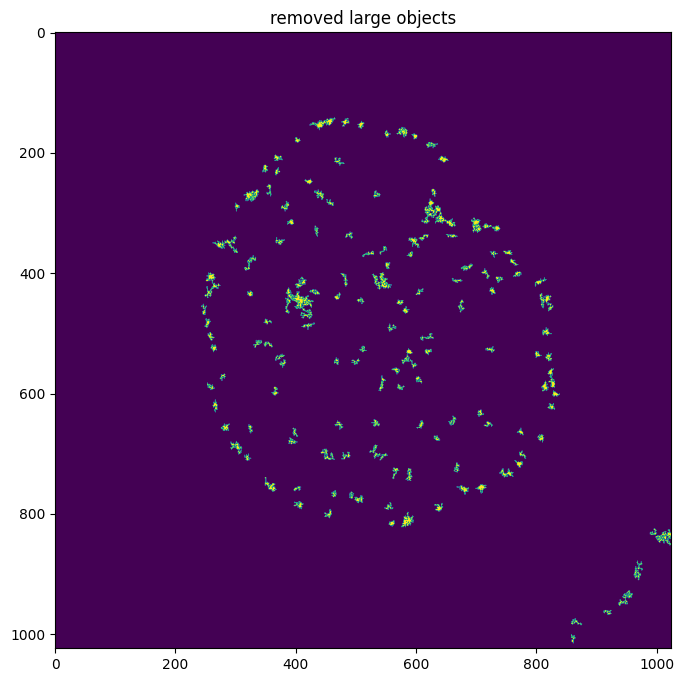

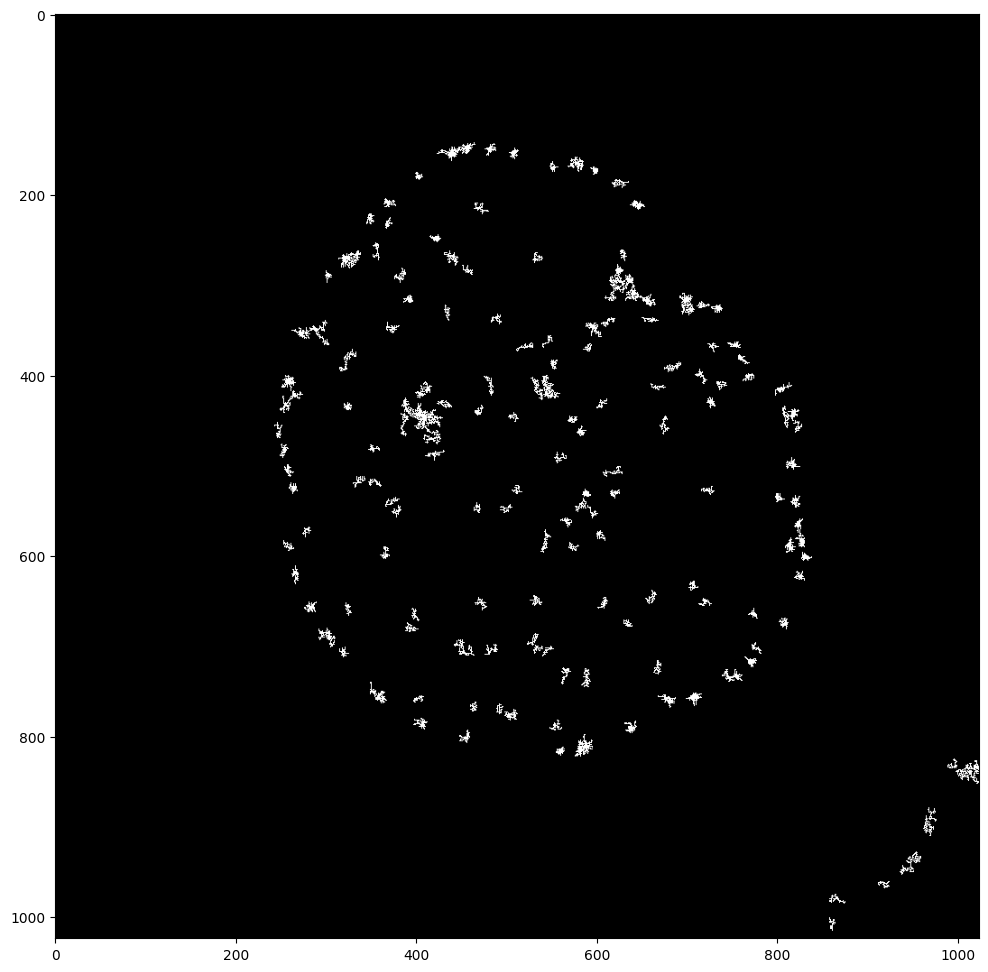

In [24]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1, 'lower': None}
)
# rosette_thresholds = topofilters.get_thresholds(
#     flattened,
#     threshold_method='absolute',
#     threshold_absolute={'upper': 3.75, 'lower': None}
# )
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 40)
# plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


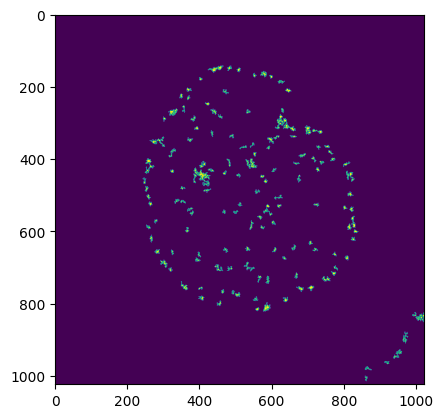

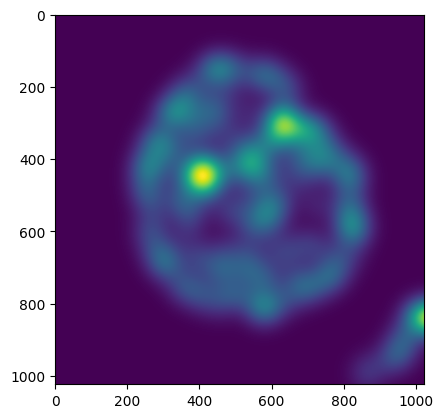

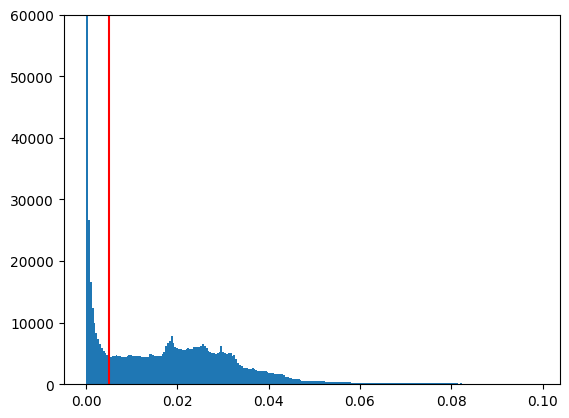

otsu threshold: 0.005


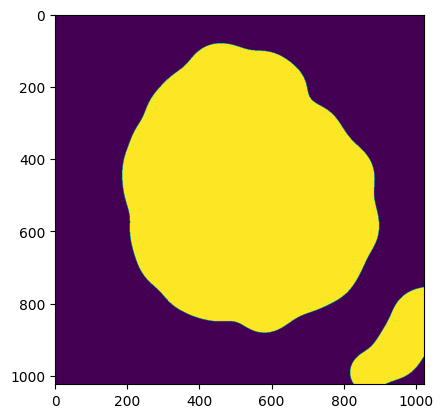

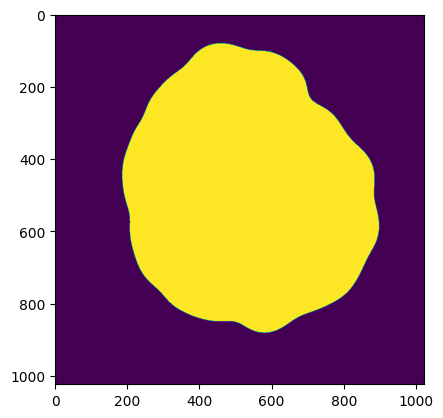

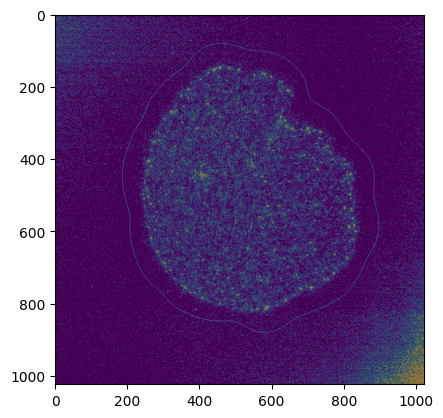

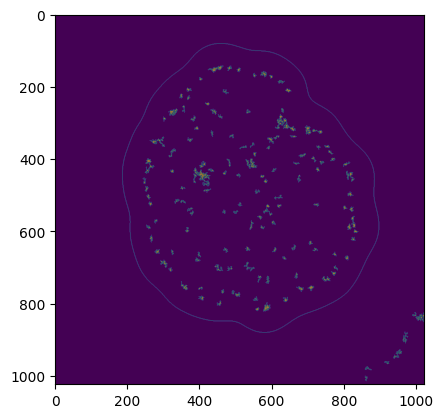

In [25]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
gauss = gaussian(labelled_rosette_mask.astype(bool), sigma=35)
plt.imshow(gauss)
plt.show()



# threshold = threshold_otsu(gauss)
threshold = 0.005

fig, ax = plt.subplots()
ax.hist(gauss.flatten(), bins='auto')
ax.set_ylim(0, 60000)
plt.axvline(x=threshold, color='r')
plt.show()

print(f'otsu threshold: {threshold}')
thresholded = gauss > threshold
plt.imshow(thresholded)
plt.show()

labelled = label(thresholded)
region_props = regionprops(labelled)
max_size = max([props.area for props in region_props])
thresholded = remove_small_objects(thresholded, min_size=max_size-1)
thresholded = ndimage.binary_fill_holes(thresholded)
plt.imshow(thresholded)
plt.show()

# Add padding (needed for erosion)
padded = np.pad(thresholded, 1)
# Erode by 1 pixel
eroded = binary_erosion(padded)
# Remove padding
eroded = eroded[1:-1, 1:-1]

# Edges is equal to the difference between the
# original image and the eroded image.
edges = thresholded.astype(int) - eroded.astype(int)
plt.imshow(rosette_mask)
plt.imshow(edges, alpha=0.5)
plt.show()

plt.imshow(edges)
plt.imshow(labelled_rosette_mask.astype(bool), alpha=0.5)
plt.show()

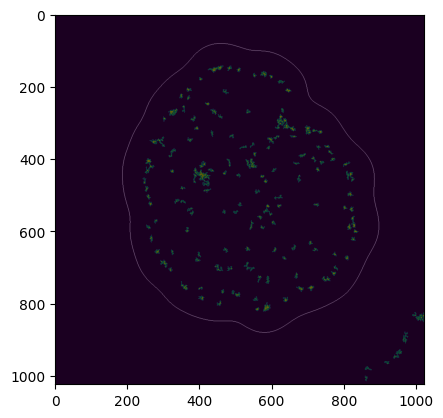

mean distance: 137.32941741109317
std dev distance: 75.73774264664583


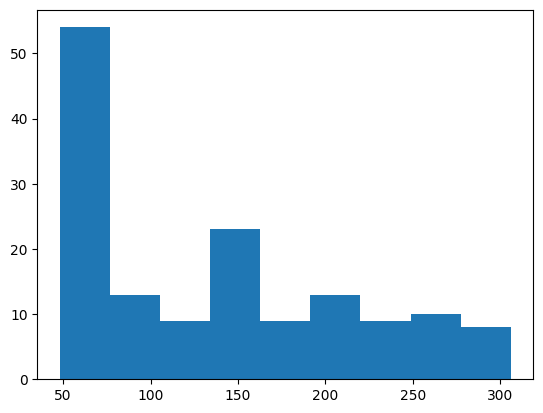

distance threshold: 118.39498174943172
points shape: (70, 2)


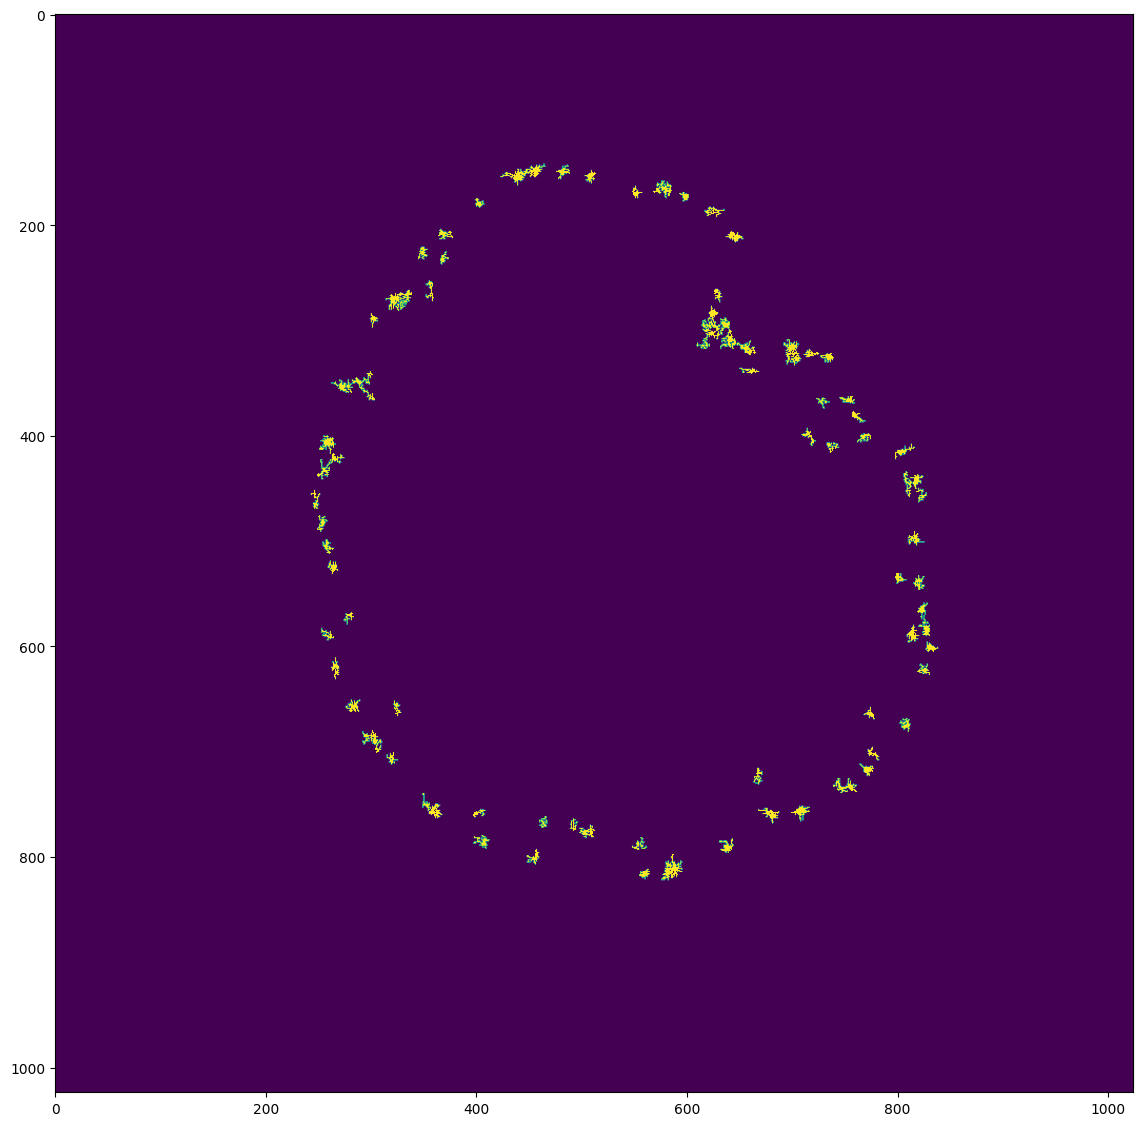

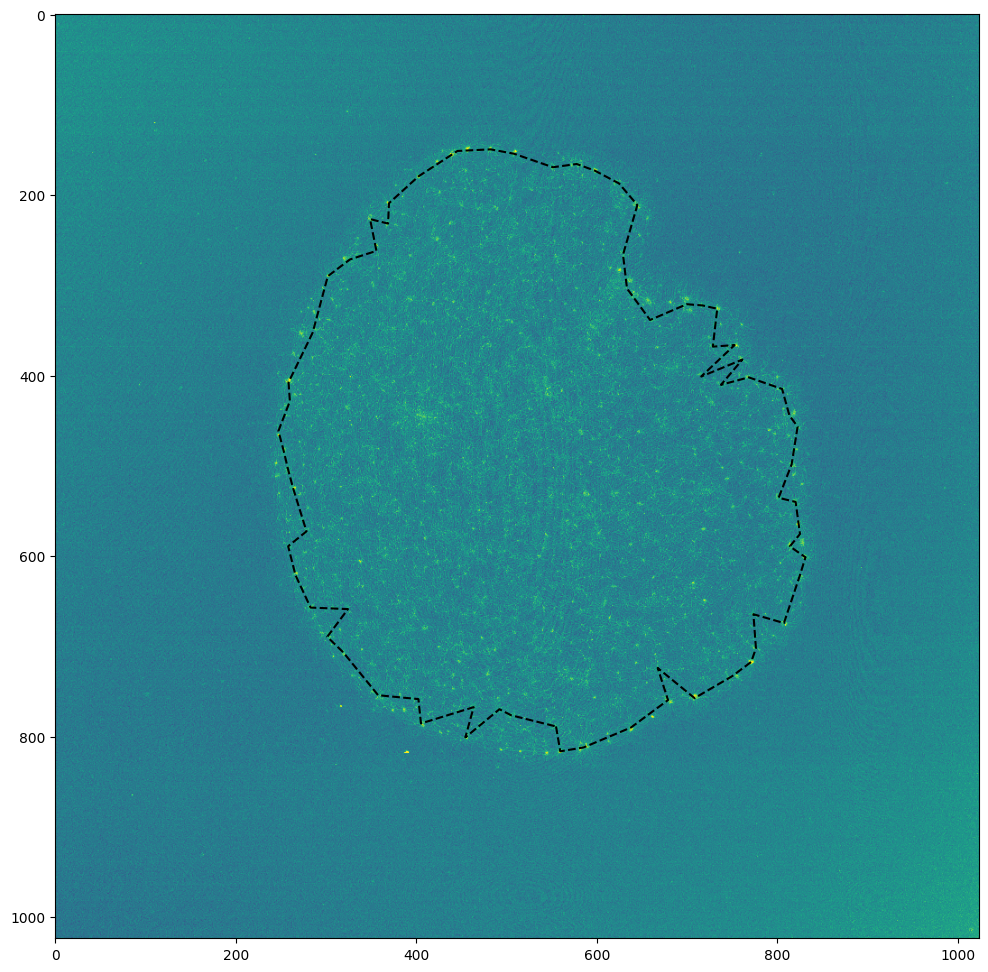

In [26]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.imshow(edges, alpha=0.6, cmap='gray')
plt.show()

edge_positions = np.transpose(np.nonzero(edges))
region_props = regionprops(labelled_rosette_mask)
min_distances = np.zeros(len(region_props))
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    min_distances[props_index] = min_distance

print(f'mean distance: {np.mean(min_distances)}')
print(f'std dev distance: {np.std(min_distances)}')
plt.hist(min_distances, bins='auto')
plt.show()
distance_threshold = np.mean(min_distances) - 0.25 * np.std(min_distances)
print(f'distance threshold: {distance_threshold}')

removed_too_far_points = labelled_rosette_mask.copy()
points = np.array([])
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    if min_distance > distance_threshold:
        removed_too_far_points[removed_too_far_points == proplabel] = 0
    else:
        points = np.append(points, centroid).reshape(-1, 2)

points = np.array(points)
print(f'points shape: {points.shape}')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(removed_too_far_points.astype(bool))
plt.show()

# Find centroids of remaining points
labelled = label(removed_too_far_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(flattened, vmin=-3, vmax=4)
ax.plot(xs, ys, 'k--')

plt.show()


In [9]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [10]:
def point_distances(points: np.ndarray):
    distance_matrix = distance.cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [11]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [12]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume

    return {
        'areas': areas,
        'volumes': volumes,
        'number_of_regions': len(region_props)
    }

number of nodes in perimeter: 88
area: 1447367.70925 px^2
mean distance between edge points: 874.9865480747126 px
perimeter: 4390.843812129535 px
mean node area: 118.68181818181819 px^2
mean node volume: 240.13470639138842 px^2nm


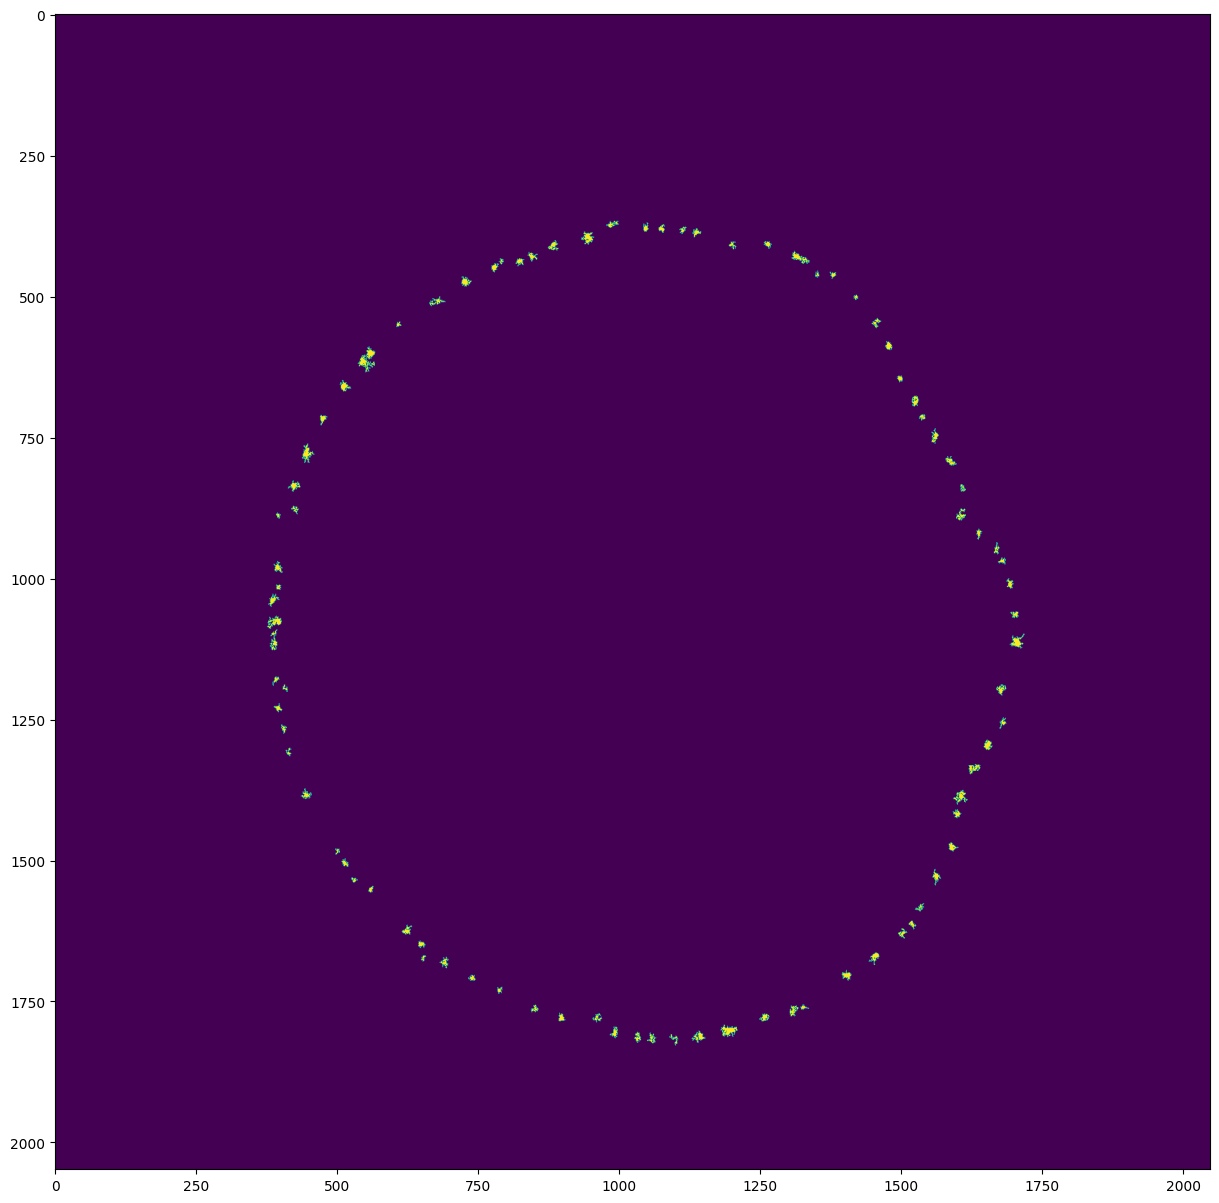

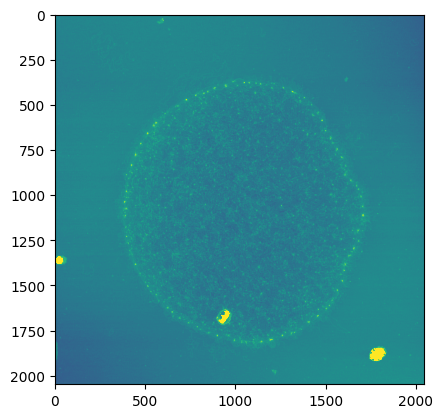

In [13]:


num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
area = shoelace(sorted)
print(f'area: {area} px^2')
mean_edge_point_distance = np.mean(point_distances(sorted))
print(f'mean distance between edge points: {mean_edge_point_distance} px')
perimeter = polygon_perimeter(sorted)
print(f'perimeter: {perimeter} px')

# WATERSHED FOR ACCURATE AREA AND VOLUME STATS

region_statistics = region_stats(labelled_image=labelled, image=flattened)
areas = region_statistics['areas']
print(f'mean node area: {np.mean(areas)} px^2')
volumes = region_statistics['volumes']
print(f'mean node volume: {np.mean(volumes)} px^2nm')

fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(labelled.astype(bool))
plt.show()
plt.imshow(flattened, vmin=-3, vmax=4)

# fig, ax = plt.subplots()
# plt.fill(sorted[:, 0], sorted[:, 1])
# plt.scatter(x=sorted[:, 0], y=sorted[:, 1])
# ax.set_aspect(1)